In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Đang xử lý TAPLA enhancement...


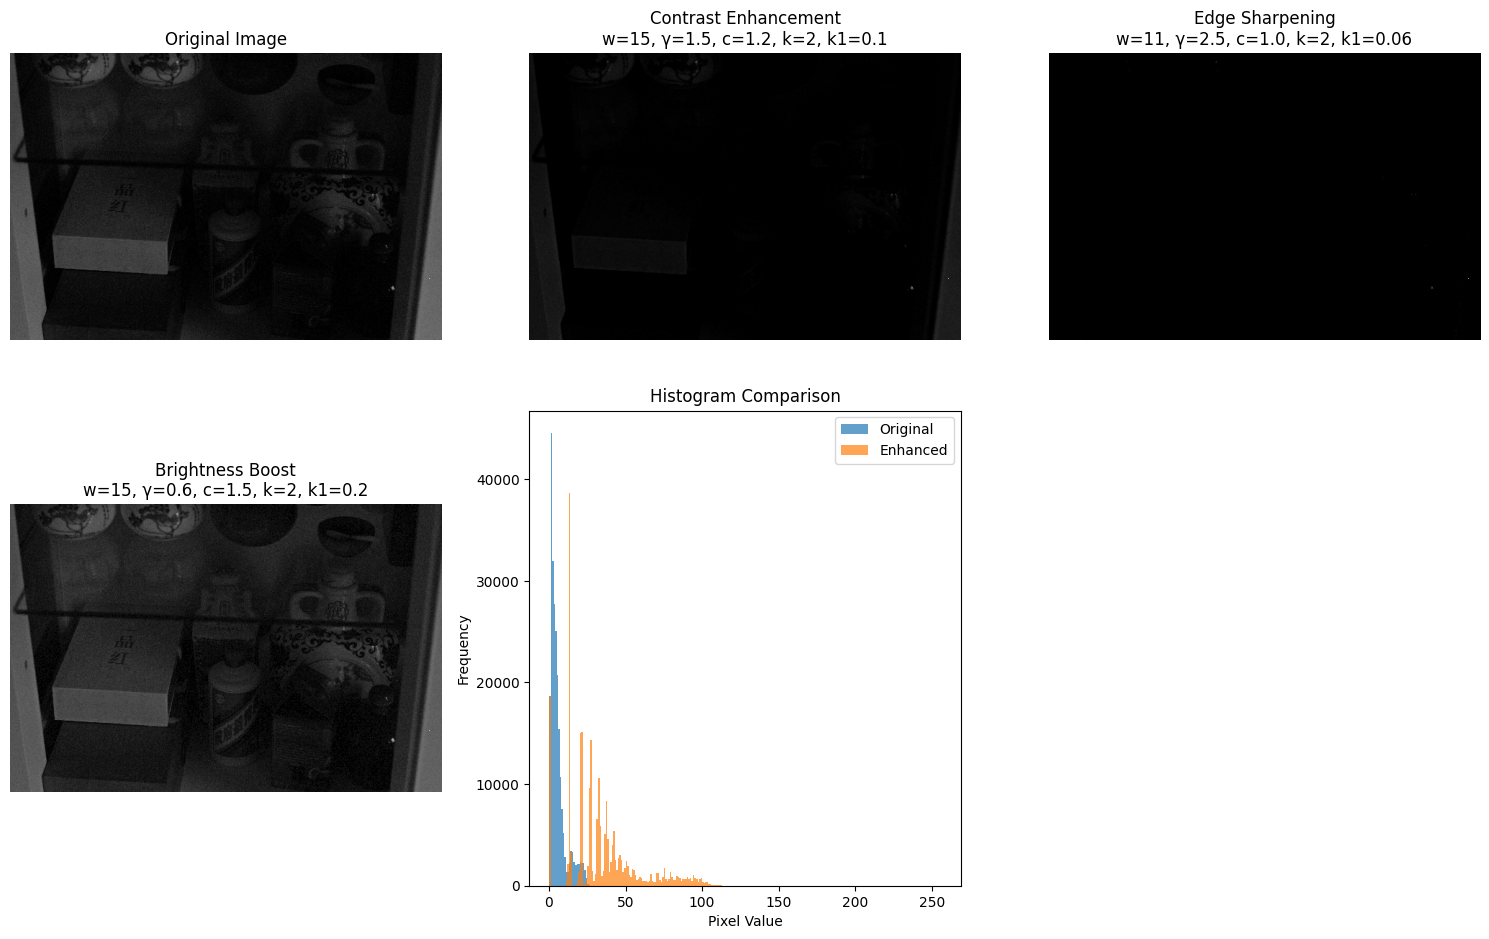

✓ Hoàn thành! Kết quả đã được lưu vào 'tapla_results.png'

Hướng dẫn điều chỉnh tham số:
- w (window size): 7-31, tăng để smooth hơn
- gamma: <1 làm sáng, >1 làm tối, điều chỉnh contrast
- c: >1 tăng brightness tổng thể
- k: >0 sharpen edges, <0 smooth image
- k1: 0-0.3, điều chỉnh ngưỡng adaptive (cao hơn = ít vùng được enhance)


In [2]:


def compute_integral_average(img):
    """
    Tính integral average image để tối ưu hóa việc tính local mean.
    
    Args:
        img: Ảnh đầu vào đã chuẩn hóa [0, 1]
    
    Returns:
        integral_avg: Ảnh tích phân trung bình
    """
    h, w = img.shape
    integral_avg = np.zeros_like(img, dtype=np.float64)
    
    # Tính cumulative sum theo hàng và cột
    cumsum = np.cumsum(np.cumsum(img, axis=0), axis=1)
    
    # Tính integral average
    for i in range(h):
        for j in range(w):
            area = (i + 1) * (j + 1)
            integral_avg[i, j] = cumsum[i, j] / area
    
    return integral_avg

def compute_local_mean_fast(img, window_size):
    """
    Tính local mean nhanh sử dụng box filter (không phụ thuộc vào window size).
    
    Args:
        img: Ảnh đầu vào [0, 1]
        window_size: Kích thước cửa sổ
    
    Returns:
        local_mean: Ảnh chứa giá trị trung bình cục bộ
    """
    # Sử dụng box filter của OpenCV (tối ưu hơn nhiều)
    kernel_size = (window_size, window_size)
    local_mean = cv2.boxFilter(img, -1, kernel_size, normalize=True, borderType=cv2.BORDER_REPLICATE)
    
    return local_mean

def compute_local_threshold(img, local_mean, k1, epsilon=1e-10):
    """
    Tính local threshold T(x,y) theo công thức trong bài báo.
    
    Args:
        img: Ảnh đầu vào [0, 1]
        local_mean: Local mean m(x,y)
        k1: Hệ số bias threshold
        epsilon: Giá trị nhỏ để tránh chia 0
    
    Returns:
        threshold: Local threshold T(x,y)
    """
    # Tính local mean deviation
    delta = np.abs(img - local_mean)
    
    # Tránh chia cho 0 và giá trị >= 1
    delta = np.clip(delta, 0, 1 - epsilon)
    
    # Công thức threshold: T(x,y) = m(x,y) * [1 + k1 * (delta/(1-delta) - 1)]
    ratio = delta / (1 - delta + epsilon)
    threshold = local_mean * (1 + k1 * (ratio - 1))
    
    return threshold

def tapla_transform(img, threshold, gamma, c, k, epsilon=1e-10):
    """
    Áp dụng phép biến đổi TAPLA.
    
    Args:
        img: Ảnh đầu vào [0, 1]
        threshold: Local threshold T(x,y)
        gamma: Hệ số gamma
        c: Hằng số độ sáng
        k: Hệ số sharpness/smoothness
        epsilon: Giá trị nhỏ để tránh log(0)
    
    Returns:
        enhanced: Ảnh đã tăng cường [0, 1]
    """
    # Tính d = r - T(x,y)
    d = img - threshold
    
    # Tính các hệ số
    brightness_factor = c * (1 + k * d)
    gamma_factor = gamma * (1 - k * d)
    
    # Đảm bảo không có giá trị âm khi tính power
    img_safe = np.clip(img, epsilon, 1.0)
    
    # Áp dụng công thức: s = c(1+kd) * r^(gamma(1-kd))
    enhanced = brightness_factor * np.power(img_safe, gamma_factor)
    
    # Clip về [0, 1]
    enhanced = np.clip(enhanced, 0, 1)
    
    return enhanced

def tapla_enhance(image, w=15, gamma=1.5, c=1.2, k=2, k1=0.1):
    """
    Hàm chính thực hiện TAPLA enhancement.
    
    Args:
        image: Ảnh đầu vào (uint8, grayscale hoặc color)
        w: Kích thước cửa sổ (phải là số lẻ)
        gamma: Hệ số mũ power-law
        c: Hằng số brightness
        k: Hệ số sharpness/smoothness
        k1: Hệ số bias threshold
    
    Returns:
        enhanced_image: Ảnh đã tăng cường (uint8)
    """
    # Đảm bảo window size là số lẻ
    if w % 2 == 0:
        w += 1
    
    # Chuyển sang float và chuẩn hóa về [0, 1]
    img_normalized = image.astype(np.float32) / 255.0
    
    # Xử lý ảnh màu
    if len(img_normalized.shape) == 3:
        # Tách các kênh
        channels = cv2.split(img_normalized)
        enhanced_channels = []
        
        # Áp dụng TAPLA cho từng kênh
        for channel in channels:
            # Tính local mean
            local_mean = compute_local_mean_fast(channel, w)
            
            # Tính local threshold
            threshold = compute_local_threshold(channel, local_mean, k1)
            
            # Áp dụng transform
            enhanced_channel = tapla_transform(channel, threshold, gamma, c, k)
            enhanced_channels.append(enhanced_channel)
        
        # Gộp các kênh lại
        enhanced_normalized = cv2.merge(enhanced_channels)
    
    # Xử lý ảnh xám
    else:
        # Tính local mean
        local_mean = compute_local_mean_fast(img_normalized, w)
        
        # Tính local threshold
        threshold = compute_local_threshold(img_normalized, local_mean, k1)
        
        # Áp dụng transform
        enhanced_normalized = tapla_transform(img_normalized, threshold, gamma, c, k)
    
    # Chuyển về uint8 [0, 255]
    enhanced_image = (enhanced_normalized * 255).astype(np.uint8)
    
    return enhanced_image

# ==================== MAIN DEMO ====================
if __name__ == "__main__":
    # Đọc ảnh mẫu (thay đổi đường dẫn phù hợp)
    # Bạn có thể thử với ảnh xám hoặc màu
    
    # Tạo ảnh test (ảnh tối với low contrast)
    img = cv2.imread("D:\\Huce\\XLA\\LoLI-Street Dataset\\Test_50img_LL\\45.png")  # Thay bằng ảnh của bạn
    
    # Nếu không có ảnh, tạo ảnh test
    if img is None:
        print("Tạo ảnh test mẫu...")
        # Tạo ảnh với gradient và noise
        h, w = 400, 400
        img = np.zeros((h, w), dtype=np.uint8)
        for i in range(h):
            img[i, :] = int(50 + 100 * i / h)  # Gradient tối
        # Thêm noise
        noise = np.random.normal(0, 15, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        
        # Thêm một số vùng tối hơn
        cv2.rectangle(img, (50, 50), (150, 150), 30, -1)
        cv2.circle(img, (300, 300), 50, 200, -1)
    
    # Chuyển sang grayscale nếu là ảnh màu (hoặc giữ nguyên)
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img.copy()
    
    print("Đang xử lý TAPLA enhancement...")
    
    # Thử các tham số khác nhau
    configs = [
        {"name": "Contrast Enhancement", "w": 15, "gamma": 1.5, "c": 1.2, "k": 2, "k1": 0.1},
        {"name": "Edge Sharpening", "w": 11, "gamma": 2.5, "c": 1.0, "k": 2, "k1": 0.06},
        {"name": "Brightness Boost", "w": 15, "gamma": 0.6, "c": 1.5, "k": 2, "k1": 0.2},
    ]
    
    # Hiển thị kết quả
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    for idx, config in enumerate(configs):
        enhanced = tapla_enhance(
            img_gray, 
            w=config["w"], 
            gamma=config["gamma"], 
            c=config["c"], 
            k=config["k"], 
            k1=config["k1"]
        )
        
        plt.subplot(2, 3, idx + 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title(f'{config["name"]}\nw={config["w"]}, γ={config["gamma"]}, c={config["c"]}, k={config["k"]}, k1={config["k1"]}')
        plt.axis('off')
    
    # Histogram comparison
    plt.subplot(2, 3, 5)
    plt.hist(img_gray.ravel(), bins=256, range=(0, 256), alpha=0.7, label='Original')
    plt.hist(enhanced.ravel(), bins=256, range=(0, 256), alpha=0.7, label='Enhanced')
    plt.legend()
    plt.title('Histogram Comparison')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('tapla_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Hoàn thành! Kết quả đã được lưu vào 'tapla_results.png'")
    print("\nHướng dẫn điều chỉnh tham số:")
    print("- w (window size): 7-31, tăng để smooth hơn")
    print("- gamma: <1 làm sáng, >1 làm tối, điều chỉnh contrast")
    print("- c: >1 tăng brightness tổng thể")
    print("- k: >0 sharpen edges, <0 smooth image")
    print("- k1: 0-0.3, điều chỉnh ngưỡng adaptive (cao hơn = ít vùng được enhance)")

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

def compute_integral_average(img):
    """
    Tính integral average image để tối ưu hóa việc tính local mean.
    
    Args:
        img: Ảnh đầu vào đã chuẩn hóa [0, 1]
    
    Returns:
        integral_avg: Ảnh tích phân trung bình
    """
    h, w = img.shape
    integral_avg = np.zeros_like(img, dtype=np.float64)
    
    # Tính cumulative sum theo hàng và cột
    cumsum = np.cumsum(np.cumsum(img, axis=0), axis=1)
    
    # Tính integral average
    for i in range(h):
        for j in range(w):
            area = (i + 1) * (j + 1)
            integral_avg[i, j] = cumsum[i, j] / area
    
    return integral_avg

def compute_local_mean_fast(img, window_size):
    """
    Tính local mean nhanh sử dụng box filter (không phụ thuộc vào window size).
    
    Args:
        img: Ảnh đầu vào [0, 1]
        window_size: Kích thước cửa sổ
    
    Returns:
        local_mean: Ảnh chứa giá trị trung bình cục bộ
    """
    # Sử dụng box filter của OpenCV (tối ưu hơn nhiều)
    kernel_size = (window_size, window_size)
    local_mean = cv2.boxFilter(img, -1, kernel_size, normalize=True, borderType=cv2.BORDER_REPLICATE)
    
    return local_mean

def compute_local_threshold(img, local_mean, k1, epsilon=1e-10):
    """
    Tính local threshold T(x,y) theo công thức trong bài báo.
    
    Args:
        img: Ảnh đầu vào [0, 1]
        local_mean: Local mean m(x,y)
        k1: Hệ số bias threshold
        epsilon: Giá trị nhỏ để tránh chia 0
    
    Returns:
        threshold: Local threshold T(x,y)
    """
    # Tính local mean deviation
    delta = np.abs(img - local_mean)
    
    # Tránh chia cho 0 và giá trị >= 1
    delta = np.clip(delta, 0, 1 - epsilon)
    
    # Công thức threshold: T(x,y) = m(x,y) * [1 + k1 * (delta/(1-delta) - 1)]
    ratio = delta / (1 - delta + epsilon)
    threshold = local_mean * (1 + k1 * (ratio - 1))
    
    return threshold

def tapla_transform(img, threshold, gamma, c, k, epsilon=1e-10):
    """
    Áp dụng phép biến đổi TAPLA.
    
    Args:
        img: Ảnh đầu vào [0, 1]
        threshold: Local threshold T(x,y)
        gamma: Hệ số gamma
        c: Hằng số độ sáng
        k: Hệ số sharpness/smoothness
        epsilon: Giá trị nhỏ để tránh log(0)
    
    Returns:
        enhanced: Ảnh đã tăng cường [0, 1]
    """
    # Tính d = r - T(x,y)
    d = img - threshold
    
    # Tính các hệ số
    brightness_factor = c * (1 + k * d)
    gamma_factor = gamma * (1 - k * d)
    
    # Đảm bảo không có giá trị âm khi tính power
    img_safe = np.clip(img, epsilon, 1.0)
    
    # Áp dụng công thức: s = c(1+kd) * r^(gamma(1-kd))
    enhanced = brightness_factor * np.power(img_safe, gamma_factor)
    
    # Clip về [0, 1]
    enhanced = np.clip(enhanced, 0, 1)
    
    return enhanced

def tapla_enhance(image, w=15, gamma=1.5, c=1.2, k=2, k1=0.1, preserve_color=True):
    """
    Hàm chính thực hiện TAPLA enhancement.
    
    Args:
        image: Ảnh đầu vào (uint8, grayscale hoặc color)
        w: Kích thước cửa sổ (phải là số lẻ)
        gamma: Hệ số mũ power-law
        c: Hằng số brightness
        k: Hệ số sharpness/smoothness
        k1: Hệ số bias threshold
        preserve_color: Nếu True, xử lý trong không gian HSV để giữ màu sắc
    
    Returns:
        enhanced_image: Ảnh đã tăng cường (uint8), giữ nguyên định dạng màu của input
    """
    # Đảm bảo window size là số lẻ
    if w % 2 == 0:
        w += 1
    
    is_color = len(image.shape) == 3
    
    # Chuyển sang float và chuẩn hóa về [0, 1]
    img_normalized = image.astype(np.float32) / 255.0
    
    # Xử lý ảnh màu
    if is_color:
        if preserve_color:
            # Chuyển sang HSV để giữ nguyên Hue (màu sắc)
            img_hsv = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(img_hsv)
            
            # Chỉ xử lý kênh V (Value/Brightness)
            local_mean = compute_local_mean_fast(v, w)
            threshold = compute_local_threshold(v, local_mean, k1)
            v_enhanced = tapla_transform(v, threshold, gamma, c, k)
            
            # Ghép lại và chuyển về BGR
            img_hsv_enhanced = cv2.merge([h, s, v_enhanced])
            enhanced_normalized = cv2.cvtColor(img_hsv_enhanced, cv2.COLOR_HSV2BGR)
        else:
            # Xử lý từng kênh RGB riêng biệt
            channels = cv2.split(img_normalized)
            enhanced_channels = []
            
            for channel in channels:
                local_mean = compute_local_mean_fast(channel, w)
                threshold = compute_local_threshold(channel, local_mean, k1)
                enhanced_channel = tapla_transform(channel, threshold, gamma, c, k)
                enhanced_channels.append(enhanced_channel)
            
            enhanced_normalized = cv2.merge(enhanced_channels)
    
    # Xử lý ảnh xám
    else:
        local_mean = compute_local_mean_fast(img_normalized, w)
        threshold = compute_local_threshold(img_normalized, local_mean, k1)
        enhanced_normalized = tapla_transform(img_normalized, threshold, gamma, c, k)
    
    # Chuyển về uint8 [0, 255]
    enhanced_image = (enhanced_normalized * 255).astype(np.uint8)
    
    return enhanced_image

# ==================== FOLDER PROCESSING ====================
def process_folder(input_folder, output_folder, w=15, gamma=1.5, c=1.2, k=2, k1=0.1, preserve_color=True):
    """
    Xử lý tất cả ảnh trong một folder.
    
    Args:
        input_folder: Đường dẫn folder chứa ảnh đầu vào
        output_folder: Đường dẫn folder lưu ảnh kết quả
        w, gamma, c, k, k1: Các tham số TAPLA
        preserve_color: Giữ màu sắc gốc (True) hay xử lý từng kênh RGB (False)
    
    Returns:
        processed_files: Danh sách tên file đã xử lý
    """
    # Tạo output folder nếu chưa có
    os.makedirs(output_folder, exist_ok=True)
    
    # Danh sách định dạng ảnh hỗ trợ
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    
    processed_files = []
    failed_files = []
    
    # Lấy tất cả file ảnh
    image_files = [f for f in input_path.iterdir() 
                   if f.is_file() and f.suffix.lower() in image_extensions]
    
    if not image_files:
        print(f"⚠️ Không tìm thấy ảnh nào trong folder: {input_folder}")
        return []
    
    print(f"🔍 Tìm thấy {len(image_files)} ảnh trong folder")
    print(f"📁 Input:  {input_folder}")
    print(f"📁 Output: {output_folder}")
    print(f"⚙️  Tham số: w={w}, γ={gamma}, c={c}, k={k}, k1={k1}")
    print(f"🎨 Preserve Color: {preserve_color}")
    print("-" * 60)
    
    for idx, img_file in enumerate(image_files, 1):
        try:
            # Đọc ảnh (giữ nguyên màu)
            img = cv2.imread(str(img_file))
            
            if img is None:
                print(f"❌ [{idx}/{len(image_files)}] Không đọc được: {img_file.name}")
                failed_files.append(img_file.name)
                continue
            
            # Xử lý TAPLA
            enhanced = tapla_enhance(img, w=w, gamma=gamma, c=c, k=k, k1=k1, 
                                    preserve_color=preserve_color)
            
            # Lưu kết quả (giữ nguyên tên file)
            output_file = output_path / img_file.name
            cv2.imwrite(str(output_file), enhanced)
            
            processed_files.append(img_file.name)
            print(f"✓ [{idx}/{len(image_files)}] {img_file.name} - Shape: {img.shape}")
            
        except Exception as e:
            print(f"❌ [{idx}/{len(image_files)}] Lỗi xử lý {img_file.name}: {str(e)}")
            failed_files.append(img_file.name)
    
    print("-" * 60)
    print(f"✅ Hoàn thành: {len(processed_files)}/{len(image_files)} ảnh")
    
    if failed_files:
        print(f"⚠️  Lỗi: {len(failed_files)} ảnh - {', '.join(failed_files)}")
    
    return processed_files

def process_single_image(input_path, output_path=None, w=15, gamma=1.5, c=1.2, k=2, k1=0.1, 
                        preserve_color=True, show_result=True):
    """
    Xử lý một ảnh đơn lẻ.
    
    Args:
        input_path: Đường dẫn ảnh đầu vào
        output_path: Đường dẫn lưu kết quả (None = tự động tạo)
        w, gamma, c, k, k1: Các tham số TAPLA
        preserve_color: Giữ màu sắc (True) hay xử lý từng kênh (False)
        show_result: Hiển thị kết quả so sánh
    
    Returns:
        enhanced: Ảnh đã tăng cường
    """
    # Đọc ảnh
    img = cv2.imread(input_path)
    
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {input_path}")
    
    print(f"📷 Đang xử lý: {Path(input_path).name}")
    print(f"   Kích thước: {img.shape}")
    print(f"   Loại: {'Màu' if len(img.shape) == 3 else 'Xám'}")
    
    # Xử lý
    enhanced = tapla_enhance(img, w=w, gamma=gamma, c=c, k=k, k1=k1, preserve_color=preserve_color)
    
    # Tạo tên file output
    if output_path is None:
        input_file = Path(input_path)
        output_path = input_file.parent / f"{input_file.stem}_enhanced{input_file.suffix}"
    
    # Lưu kết quả
    cv2.imwrite(str(output_path), enhanced)
    print(f"✅ Đã lưu: {output_path}")
    
    # Hiển thị kết quả
    if show_result:
        plt.figure(figsize=(14, 6))
        
        # Original
        plt.subplot(1, 2, 1)
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(f'Original\nSize: {img.shape[1]}x{img.shape[0]}')
        plt.axis('off')
        
        # Enhanced
        plt.subplot(1, 2, 2)
        if len(enhanced.shape) == 3:
            plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(enhanced, cmap='gray')
        plt.title(f'TAPLA Enhanced\nw={w}, γ={gamma}, c={c}, k={k}, k1={k1}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(str(Path(output_path).parent / 'comparison.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    return enhanced

# ==================== MAIN DEMO ====================
if __name__ == "__main__":
    
    # ============ CẤU HÌNH ============
    MODE = "folder"  # Chọn: "single" hoặc "folder"
    
    # Đường dẫn
    INPUT_FOLDER = r"D:\Huce\XLA\LoLI-Street Dataset\Test_input_40img_H"      # Folder chứa ảnh đầu vào
    OUTPUT_FOLDER = r"D:\Huce\XLA\LoLI-Street Dataset\Test_output_40img_H"    # Folder lưu kết quả
    SINGLE_IMAGE_PATH = "test.jpg"     # Đường dẫn ảnh đơn (nếu MODE="single")
    
    # Tham số TAPLA
    PARAMS = {
        "w": 11,          # Window size (7-31)
        "gamma": 0.5,     # Power-law gamma (0.5-2.5)
        "c": 1,         # Brightness constant (1.0-2.0)
        "k": 1.5,           # Sharpness/smoothness (-1 to 4)
        "k1": 0.08,        # Threshold bias (0.0-0.3)
        "preserve_color": True  # True: giữ màu gốc (HSV), False: xử lý từng kênh RGB
    }
    
    # ============ XỬ LÝ ============
    print("=" * 60)
    print("🚀 TAPLA IMAGE ENHANCEMENT")
    print("=" * 60)
    
    if MODE == "folder":
        # Xử lý cả folder
        processed = process_folder(
            INPUT_FOLDER, 
            OUTPUT_FOLDER,
            **PARAMS
        )
        
        if processed:
            print(f"\n🎉 Thành công! Xem kết quả tại: {OUTPUT_FOLDER}")
        
    elif MODE == "single":
        # Xử lý ảnh đơn
        try:
            enhanced = process_single_image(
                SINGLE_IMAGE_PATH,
                show_result=True,
                **PARAMS
            )
            print("\n🎉 Hoàn thành!")
        except Exception as e:
            print(f"\n❌ Lỗi: {e}")
    
    else:
        print("❌ MODE không hợp lệ! Chọn 'single' hoặc 'folder'")
    
    print("\n" + "=" * 60)
    print("📚 HƯỚNG DẪN THAM SỐ:")
    print("  • w (7-31):     Kích thước cửa sổ, tăng để smooth hơn")
    print("  • gamma:        <1 làm sáng, >1 tăng contrast")
    print("  • c (1.0-2.0):  Điều chỉnh độ sáng tổng thể")
    print("  • k:            >0 sharpen edges, <0 smooth image")
    print("  • k1 (0-0.3):   Điều chỉnh ngưỡng adaptive")
    print("  • preserve_color: True = giữ màu gốc (HSV), False = xử lý RGB riêng")
    print("=" * 60)

🚀 TAPLA IMAGE ENHANCEMENT
🔍 Tìm thấy 10 ảnh trong folder
📁 Input:  D:\Huce\XLA\LoLI-Street Dataset\Test_input_40img_H
📁 Output: D:\Huce\XLA\LoLI-Street Dataset\Test_output_40img_H
⚙️  Tham số: w=11, γ=0.5, c=1, k=1.5, k1=0.08
🎨 Preserve Color: True
------------------------------------------------------------
✓ [1/10] 10.png - Shape: (400, 600, 3)
✓ [2/10] 13.png - Shape: (400, 600, 3)
✓ [3/10] 14.png - Shape: (400, 600, 3)
✓ [4/10] 15.png - Shape: (400, 600, 3)
✓ [5/10] 16.png - Shape: (400, 600, 3)
✓ [6/10] 17.png - Shape: (400, 600, 3)
✓ [7/10] 2.png - Shape: (400, 600, 3)
✓ [8/10] 5.png - Shape: (400, 600, 3)
✓ [9/10] 6.png - Shape: (400, 600, 3)
✓ [10/10] 9.png - Shape: (400, 600, 3)
------------------------------------------------------------
✅ Hoàn thành: 10/10 ảnh

🎉 Thành công! Xem kết quả tại: D:\Huce\XLA\LoLI-Street Dataset\Test_output_40img_H

📚 HƯỚNG DẪN THAM SỐ:
  • w (7-31):     Kích thước cửa sổ, tăng để smooth hơn
  • gamma:        <1 làm sáng, >1 tăng contrast
  • c (1

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_eme(image, block_size=8):
    """
    Tính EME (Measure of Enhancement by Entropy) theo công thức trong bài báo.
    
    Args:
        image: Ảnh đầu vào (uint8 hoặc float)
        block_size: Kích thước block để tính EME
    
    Returns:
        eme_value: Giá trị EME (cao hơn = tốt hơn)
    """
    # Chuyển sang grayscale nếu là ảnh màu
    if len(image.shape) == 3:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = image.copy()
    
    # Chuyển về float [0, 1]
    if img_gray.dtype == np.uint8:
        img_gray = img_gray.astype(np.float64) / 255.0
    else:
        img_gray = img_gray.astype(np.float64)
    
    h, w = img_gray.shape
    
    # Số lượng block
    p = h // block_size
    q = w // block_size
    
    if p == 0 or q == 0:
        return 0.0
    
    eme = 0.0
    epsilon = 1e-10
    
    # Duyệt qua các block
    for i in range(p):
        for j in range(q):
            # Lấy block
            block = img_gray[i*block_size:(i+1)*block_size, 
                            j*block_size:(j+1)*block_size]
            
            # Tính min và max trong block
            I_min = np.min(block)
            I_max = np.max(block)
            
            # Tính EME cho block (theo công thức Eqn 16 trong bài báo)
            if I_min > 0:
                eme += np.log((I_max + epsilon) / (I_min + epsilon))
    
    # Trung bình
    eme = eme / (p * q)
    
    return eme

def compute_metrics(original, enhanced):
    """
    Tính các chỉ số đánh giá: PSNR, SSIM, EME.
    
    Args:
        original: Ảnh gốc (uint8)
        enhanced: Ảnh đã tăng cường (uint8)
    
    Returns:
        metrics: Dictionary chứa các chỉ số
    """
    metrics = {}
    
    # Chuyển sang grayscale nếu là ảnh màu (để tính PSNR, SSIM)
    if len(original.shape) == 3:
        original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    else:
        original_gray = original
        enhanced_gray = enhanced
    
    # 1. PSNR (Peak Signal-to-Noise Ratio)
    # Cao hơn = tốt hơn, thường > 30 dB là tốt
    try:
        psnr_value = psnr(original_gray, enhanced_gray, data_range=255)
        metrics['PSNR'] = psnr_value
    except Exception as e:
        metrics['PSNR'] = None
        print(f"⚠️ Lỗi tính PSNR: {e}")
    
    # 2. SSIM (Structural Similarity Index)
    # Từ -1 đến 1, cao hơn = giống gốc hơn, >0.9 là rất tốt
    try:
        ssim_value = ssim(original_gray, enhanced_gray, data_range=255)
        metrics['SSIM'] = ssim_value
    except Exception as e:
        metrics['SSIM'] = None
        print(f"⚠️ Lỗi tính SSIM: {e}")
    
    # 3. EME (Measure of Enhancement by Entropy)
    # Cao hơn = contrast tốt hơn
    try:
        eme_original = compute_eme(original)
        eme_enhanced = compute_eme(enhanced)
        metrics['EME_original'] = eme_original
        metrics['EME_enhanced'] = eme_enhanced
        metrics['EME_improvement'] = eme_enhanced - eme_original
    except Exception as e:
        metrics['EME_original'] = None
        metrics['EME_enhanced'] = None
        metrics['EME_improvement'] = None
        print(f"⚠️ Lỗi tính EME: {e}")
    
    return metrics

def print_metrics(metrics, filename=""):
    """
    In các chỉ số đánh giá một cách đẹp mắt.
    
    Args:
        metrics: Dictionary chứa các chỉ số
        filename: Tên file (tùy chọn)
    """
    if filename:
        print(f"\n{'='*60}")
        print(f"📊 Chỉ số đánh giá - {filename}")
        print(f"{'='*60}")
    else:
        print(f"\n{'='*60}")
        print(f"📊 CHỈ SỐ ĐÁNH GIÁ CHẤT LƯỢNG ẢNH")
        print(f"{'='*60}")
    
    # PSNR
    if metrics.get('PSNR') is not None:
        psnr_val = metrics['PSNR']
        if psnr_val >= 40:
            quality = "Xuất sắc ⭐⭐⭐"
        elif psnr_val >= 30:
            quality = "Tốt ⭐⭐"
        elif psnr_val >= 20:
            quality = "Trung bình ⭐"
        else:
            quality = "Cần cải thiện"
        print(f"  PSNR:  {psnr_val:.2f} dB  ({quality})")
    else:
        print(f"  PSNR:  N/A")
    
    # SSIM
    if metrics.get('SSIM') is not None:
        ssim_val = metrics['SSIM']
        if ssim_val >= 0.95:
            quality = "Rất giống gốc ⭐⭐⭐"
        elif ssim_val >= 0.85:
            quality = "Giống gốc ⭐⭐"
        elif ssim_val >= 0.70:
            quality = "Khá giống ⭐"
        else:
            quality = "Khác biệt đáng kể"
        print(f"  SSIM:  {ssim_val:.4f}  ({quality})")
    else:
        print(f"  SSIM:  N/A")
    
    # EME
    if metrics.get('EME_original') is not None:
        eme_orig = metrics['EME_original']
        eme_enh = metrics['EME_enhanced']
        eme_imp = metrics['EME_improvement']
        
        improvement_pct = (eme_imp / (eme_orig + 1e-10)) * 100
        
        if improvement_pct > 50:
            quality = "Cải thiện mạnh ⭐⭐⭐"
        elif improvement_pct > 20:
            quality = "Cải thiện tốt ⭐⭐"
        elif improvement_pct > 0:
            quality = "Cải thiện nhẹ ⭐"
        else:
            quality = "Giảm contrast"
        
        print(f"\n  EME (Contrast Enhancement):")
        print(f"    • Original:    {eme_orig:.4f}")
        print(f"    • Enhanced:    {eme_enh:.4f}")
        print(f"    • Improvement: {eme_imp:+.4f} ({improvement_pct:+.1f}%)  {quality}")
    else:
        print(f"  EME:   N/A")
    
    print(f"{'='*60}")

def save_metrics_to_file(metrics_list, output_folder):
    """
    Lưu tất cả metrics vào file CSV.
    
    Args:
        metrics_list: List of tuples (filename, metrics)
        output_folder: Folder lưu file
    """
    import csv
    
    csv_path = Path(output_folder) / "metrics_report.csv"
    
    with open(csv_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        
        # Header
        writer.writerow([
            'Filename', 'PSNR (dB)', 'SSIM', 
            'EME_Original', 'EME_Enhanced', 'EME_Improvement', 'EME_Improvement_%'
        ])
        
        # Data
        for filename, metrics in metrics_list:
            eme_imp_pct = 0
            if metrics.get('EME_improvement') is not None and metrics.get('EME_original') is not None:
                eme_imp_pct = (metrics['EME_improvement'] / (metrics['EME_original'] + 1e-10)) * 100
            
            writer.writerow([
                filename,
                f"{metrics.get('PSNR', 0):.2f}" if metrics.get('PSNR') else 'N/A',
                f"{metrics.get('SSIM', 0):.4f}" if metrics.get('SSIM') else 'N/A',
                f"{metrics.get('EME_original', 0):.4f}" if metrics.get('EME_original') else 'N/A',
                f"{metrics.get('EME_enhanced', 0):.4f}" if metrics.get('EME_enhanced') else 'N/A',
                f"{metrics.get('EME_improvement', 0):.4f}" if metrics.get('EME_improvement') else 'N/A',
                f"{eme_imp_pct:.2f}%" if metrics.get('EME_improvement') else 'N/A'
            ])
    
    print(f"\n💾 Đã lưu báo cáo metrics: {csv_path}")

def compute_integral_average(img):
    """
    Tính integral average image để tối ưu hóa việc tính local mean.
    
    Args:
        img: Ảnh đầu vào đã chuẩn hóa [0, 1]
    
    Returns:
        integral_avg: Ảnh tích phân trung bình
    """
    h, w = img.shape
    integral_avg = np.zeros_like(img, dtype=np.float64)
    
    # Tính cumulative sum theo hàng và cột
    cumsum = np.cumsum(np.cumsum(img, axis=0), axis=1)
    
    # Tính integral average
    for i in range(h):
        for j in range(w):
            area = (i + 1) * (j + 1)
            integral_avg[i, j] = cumsum[i, j] / area
    
    return integral_avg

def compute_local_mean_fast(img, window_size):
    """
    Tính local mean nhanh sử dụng box filter (không phụ thuộc vào window size).
    
    Args:
        img: Ảnh đầu vào [0, 1]
        window_size: Kích thước cửa sổ
    
    Returns:
        local_mean: Ảnh chứa giá trị trung bình cục bộ
    """
    # Sử dụng box filter của OpenCV (tối ưu hơn nhiều)
    kernel_size = (window_size, window_size)
    local_mean = cv2.boxFilter(img, -1, kernel_size, normalize=True, borderType=cv2.BORDER_REPLICATE)
    
    return local_mean

def compute_local_threshold(img, local_mean, k1, epsilon=1e-10):
    """
    Tính local threshold T(x,y) theo công thức trong bài báo.
    
    Args:
        img: Ảnh đầu vào [0, 1]
        local_mean: Local mean m(x,y)
        k1: Hệ số bias threshold
        epsilon: Giá trị nhỏ để tránh chia 0
    
    Returns:
        threshold: Local threshold T(x,y)
    """
    # Tính local mean deviation
    delta = np.abs(img - local_mean)
    
    # Tránh chia cho 0 và giá trị >= 1
    delta = np.clip(delta, 0, 1 - epsilon)
    
    # Công thức threshold: T(x,y) = m(x,y) * [1 + k1 * (delta/(1-delta) - 1)]
    ratio = delta / (1 - delta + epsilon)
    threshold = local_mean * (1 + k1 * (ratio - 1))
    
    return threshold

def tapla_transform(img, threshold, gamma, c, k, epsilon=1e-10):
    """
    Áp dụng phép biến đổi TAPLA.
    
    Args:
        img: Ảnh đầu vào [0, 1]
        threshold: Local threshold T(x,y)
        gamma: Hệ số gamma
        c: Hằng số độ sáng
        k: Hệ số sharpness/smoothness
        epsilon: Giá trị nhỏ để tránh log(0)
    
    Returns:
        enhanced: Ảnh đã tăng cường [0, 1]
    """
    # Tính d = r - T(x,y)
    d = img - threshold
    
    # Tính các hệ số
    brightness_factor = c * (1 + k * d)
    gamma_factor = gamma * (1 - k * d)
    
    # Đảm bảo không có giá trị âm khi tính power
    img_safe = np.clip(img, epsilon, 1.0)
    
    # Áp dụng công thức: s = c(1+kd) * r^(gamma(1-kd))
    enhanced = brightness_factor * np.power(img_safe, gamma_factor)
    
    # Clip về [0, 1]
    enhanced = np.clip(enhanced, 0, 1)
    
    return enhanced

def tapla_enhance(image, w=15, gamma=1.5, c=1.2, k=2, k1=0.1, preserve_color=True):
    """
    Hàm chính thực hiện TAPLA enhancement.
    
    Args:
        image: Ảnh đầu vào (uint8, grayscale hoặc color)
        w: Kích thước cửa sổ (phải là số lẻ)
        gamma: Hệ số mũ power-law
        c: Hằng số brightness
        k: Hệ số sharpness/smoothness
        k1: Hệ số bias threshold
        preserve_color: Nếu True, xử lý trong không gian HSV để giữ màu sắc
    
    Returns:
        enhanced_image: Ảnh đã tăng cường (uint8), giữ nguyên định dạng màu của input
    """
    # Đảm bảo window size là số lẻ
    if w % 2 == 0:
        w += 1
    
    is_color = len(image.shape) == 3
    
    # Chuyển sang float và chuẩn hóa về [0, 1]
    img_normalized = image.astype(np.float32) / 255.0
    
    # Xử lý ảnh màu
    if is_color:
        if preserve_color:
            # Chuyển sang HSV để giữ nguyên Hue (màu sắc)
            img_hsv = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(img_hsv)
            
            # Chỉ xử lý kênh V (Value/Brightness)
            local_mean = compute_local_mean_fast(v, w)
            threshold = compute_local_threshold(v, local_mean, k1)
            v_enhanced = tapla_transform(v, threshold, gamma, c, k)
            
            # Ghép lại và chuyển về BGR
            img_hsv_enhanced = cv2.merge([h, s, v_enhanced])
            enhanced_normalized = cv2.cvtColor(img_hsv_enhanced, cv2.COLOR_HSV2BGR)
        else:
            # Xử lý từng kênh RGB riêng biệt
            channels = cv2.split(img_normalized)
            enhanced_channels = []
            
            for channel in channels:
                local_mean = compute_local_mean_fast(channel, w)
                threshold = compute_local_threshold(channel, local_mean, k1)
                enhanced_channel = tapla_transform(channel, threshold, gamma, c, k)
                enhanced_channels.append(enhanced_channel)
            
            enhanced_normalized = cv2.merge(enhanced_channels)
    
    # Xử lý ảnh xám
    else:
        local_mean = compute_local_mean_fast(img_normalized, w)
        threshold = compute_local_threshold(img_normalized, local_mean, k1)
        enhanced_normalized = tapla_transform(img_normalized, threshold, gamma, c, k)
    
    # Chuyển về uint8 [0, 255]
    enhanced_image = (enhanced_normalized * 255).astype(np.uint8)
    
    return enhanced_image

# ==================== FOLDER PROCESSING ====================
def process_folder(input_folder, output_folder, w=15, gamma=1.5, c=1.2, k=2, k1=0.1, preserve_color=True):
    """
    Xử lý tất cả ảnh trong một folder.
    
    Args:
        input_folder: Đường dẫn folder chứa ảnh đầu vào
        output_folder: Đường dẫn folder lưu ảnh kết quả
        w, gamma, c, k, k1: Các tham số TAPLA
        preserve_color: Giữ màu sắc gốc (True) hay xử lý từng kênh RGB (False)
    
    Returns:
        processed_files: Danh sách tên file đã xử lý
    """
    # Tạo output folder nếu chưa có
    os.makedirs(output_folder, exist_ok=True)
    
    # Danh sách định dạng ảnh hỗ trợ
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    
    processed_files = []
    failed_files = []
    metrics_list = []  # Lưu metrics của tất cả ảnh
    
    # Lấy tất cả file ảnh
    image_files = [f for f in input_path.iterdir() 
                   if f.is_file() and f.suffix.lower() in image_extensions]
    
    if not image_files:
        print(f"⚠️ Không tìm thấy ảnh nào trong folder: {input_folder}")
        return []
    
    print(f"🔍 Tìm thấy {len(image_files)} ảnh trong folder")
    print(f"📁 Input:  {input_folder}")
    print(f"📁 Output: {output_folder}")
    print(f"⚙️  Tham số: w={w}, γ={gamma}, c={c}, k={k}, k1={k1}")
    print(f"🎨 Preserve Color: {preserve_color}")
    print("-" * 60)
    
    for idx, img_file in enumerate(image_files, 1):
        try:
            # Đọc ảnh (giữ nguyên màu)
            img = cv2.imread(str(img_file))
            
            if img is None:
                print(f"❌ [{idx}/{len(image_files)}] Không đọc được: {img_file.name}")
                failed_files.append(img_file.name)
                continue
            
            # Xử lý TAPLA
            enhanced = tapla_enhance(img, w=w, gamma=gamma, c=c, k=k, k1=k1, 
                                    preserve_color=preserve_color)
            
            # Lưu kết quả (giữ nguyên tên file)
            output_file = output_path / img_file.name
            cv2.imwrite(str(output_file), enhanced)
            
            # Tính metrics
            metrics = compute_metrics(img, enhanced)
            metrics_list.append((img_file.name, metrics))
            
            processed_files.append(img_file.name)
            
            # In thông tin
            print(f"✓ [{idx}/{len(image_files)}] {img_file.name} - Shape: {img.shape}")
            print(f"    PSNR: {metrics.get('PSNR', 0):.2f} dB | "
                  f"SSIM: {metrics.get('SSIM', 0):.4f} | "
                  f"EME: {metrics.get('EME_enhanced', 0):.4f} "
                  f"({metrics.get('EME_improvement', 0):+.4f})")
            
        except Exception as e:
            print(f"❌ [{idx}/{len(image_files)}] Lỗi xử lý {img_file.name}: {str(e)}")
            failed_files.append(img_file.name)
    
    print("-" * 60)
    print(f"✅ Hoàn thành: {len(processed_files)}/{len(image_files)} ảnh")
    
    if failed_files:
        print(f"⚠️  Lỗi: {len(failed_files)} ảnh - {', '.join(failed_files)}")
    
    # Lưu metrics vào CSV
    if metrics_list:
        save_metrics_to_file(metrics_list, output_folder)
        
        # Tính metrics trung bình
        print(f"\n{'='*60}")
        print(f"📈 METRICS TRUNG BÌNH CỦA TẤT CẢ ẢNH")
        print(f"{'='*60}")
        
        avg_psnr = np.mean([m[1].get('PSNR', 0) for m in metrics_list if m[1].get('PSNR')])
        avg_ssim = np.mean([m[1].get('SSIM', 0) for m in metrics_list if m[1].get('SSIM')])
        avg_eme_orig = np.mean([m[1].get('EME_original', 0) for m in metrics_list if m[1].get('EME_original')])
        avg_eme_enh = np.mean([m[1].get('EME_enhanced', 0) for m in metrics_list if m[1].get('EME_enhanced')])
        avg_eme_imp = np.mean([m[1].get('EME_improvement', 0) for m in metrics_list if m[1].get('EME_improvement')])
        
        print(f"  PSNR trung bình:         {avg_psnr:.2f} dB")
        print(f"  SSIM trung bình:         {avg_ssim:.4f}")
        print(f"  EME Original TB:         {avg_eme_orig:.4f}")
        print(f"  EME Enhanced TB:         {avg_eme_enh:.4f}")
        print(f"  EME Improvement TB:      {avg_eme_imp:+.4f} ({(avg_eme_imp/avg_eme_orig*100):+.1f}%)")
        print(f"{'='*60}")
    
    return processed_files

def process_single_image(input_path, output_path=None, w=15, gamma=1.5, c=1.2, k=2, k1=0.1, 
                        preserve_color=True, show_result=True):
    """
    Xử lý một ảnh đơn lẻ.
    
    Args:
        input_path: Đường dẫn ảnh đầu vào
        output_path: Đường dẫn lưu kết quả (None = tự động tạo)
        w, gamma, c, k, k1: Các tham số TAPLA
        preserve_color: Giữ màu sắc (True) hay xử lý từng kênh (False)
        show_result: Hiển thị kết quả so sánh
    
    Returns:
        enhanced: Ảnh đã tăng cường
    """
    # Đọc ảnh
    img = cv2.imread(input_path)
    
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {input_path}")
    
    print(f"📷 Đang xử lý: {Path(input_path).name}")
    print(f"   Kích thước: {img.shape}")
    print(f"   Loại: {'Màu' if len(img.shape) == 3 else 'Xám'}")
    
    # Xử lý
    enhanced = tapla_enhance(img, w=w, gamma=gamma, c=c, k=k, k1=k1, preserve_color=preserve_color)
    
    # Tính metrics
    metrics = compute_metrics(img, enhanced)
    
    # Tạo tên file output
    if output_path is None:
        input_file = Path(input_path)
        output_path = input_file.parent / f"{input_file.stem}_enhanced{input_file.suffix}"
    
    # Lưu kết quả
    cv2.imwrite(str(output_path), enhanced)
    print(f"✅ Đã lưu: {output_path}")
    
    # In metrics
    print_metrics(metrics, filename=Path(input_path).name)
    
    # Hiển thị kết quả
    if show_result:
        fig = plt.figure(figsize=(16, 8))
        
        # Original
        plt.subplot(2, 3, 1)
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(f'Original\nSize: {img.shape[1]}x{img.shape[0]}')
        plt.axis('off')
        
        # Enhanced
        plt.subplot(2, 3, 2)
        if len(enhanced.shape) == 3:
            plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(enhanced, cmap='gray')
        plt.title(f'TAPLA Enhanced\nw={w}, γ={gamma}, c={c}, k={k}, k1={k1}')
        plt.axis('off')
        
        # Metrics text
        plt.subplot(2, 3, 3)
        plt.axis('off')
        metrics_text = f"""
        📊 QUALITY METRICS
        {'='*25}
        
        PSNR:  {metrics.get('PSNR', 0):.2f} dB
        SSIM:  {metrics.get('SSIM', 0):.4f}
        
        EME Original:  {metrics.get('EME_original', 0):.4f}
        EME Enhanced:  {metrics.get('EME_enhanced', 0):.4f}
        EME Improve:   {metrics.get('EME_improvement', 0):+.4f}
        
        {'='*25}
        """
        plt.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
                verticalalignment='center')
        
        # Histogram comparison - Original
        plt.subplot(2, 3, 4)
        if len(img.shape) == 3:
            for i, color in enumerate(['b', 'g', 'r']):
                hist = cv2.calcHist([img], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
            plt.title('Original Histogram')
        else:
            plt.hist(img.ravel(), bins=256, range=(0, 256), alpha=0.7, color='gray')
            plt.title('Original Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.xlim([0, 256])
        
        # Histogram comparison - Enhanced
        plt.subplot(2, 3, 5)
        if len(enhanced.shape) == 3:
            for i, color in enumerate(['b', 'g', 'r']):
                hist = cv2.calcHist([enhanced], [i], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
            plt.title('Enhanced Histogram')
        else:
            plt.hist(enhanced.ravel(), bins=256, range=(0, 256), alpha=0.7, color='gray')
            plt.title('Enhanced Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.xlim([0, 256])
        
        # Difference map
        plt.subplot(2, 3, 6)
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            enhanced_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img
            enhanced_gray = enhanced
        
        diff = np.abs(enhanced_gray.astype(np.int16) - img_gray.astype(np.int16))
        plt.imshow(diff, cmap='hot')
        plt.colorbar()
        plt.title(f'Difference Map\nMean Diff: {np.mean(diff):.2f}')
        plt.axis('off')
        
        plt.tight_layout()
        comparison_path = Path(output_path).parent / f"{Path(input_path).stem}_comparison.png"
        plt.savefig(str(comparison_path), dpi=150, bbox_inches='tight')
        print(f"📊 Đã lưu comparison: {comparison_path}")
        plt.show()
    
    return enhanced

# ==================== MAIN DEMO ====================
if __name__ == "__main__":
    
    # ============ CẤU HÌNH ============
    MODE = "folder"  # Chọn: "single" hoặc "folder"
    
    # Đường dẫn
    INPUT_FOLDER = r"D:\Huce\XLA\our485\high"      # Folder chứa ảnh đầu vào
    OUTPUT_FOLDER = r"D:\Huce\XLA\output\high"    # Folder lưu kết quả
    SINGLE_IMAGE_PATH = "test.jpg"     # Đường dẫn ảnh đơn (nếu MODE="single")
    
    # Tham số TAPLA
    PARAMS = {
        "w": 11,          # Window size (7-31)
        "gamma": 2,     # Power-law gamma (0.5-2.5)
        "c": 1.2,         # Brightness constant (1.0-2.0)
        "k": 1.5,           # Sharpness/smoothness (-1 to 4)
        "k1": 0.1,        # Threshold bias (0.0-0.3)
        "preserve_color": True  # True: giữ màu gốc (HSV), False: xử lý từng kênh RGB
    }
    
    # ============ XỬ LÝ ============
    print("=" * 60)
    print("🚀 TAPLA IMAGE ENHANCEMENT")
    print("=" * 60)
    
    if MODE == "folder":
        # Xử lý cả folder
        processed = process_folder(
            INPUT_FOLDER, 
            OUTPUT_FOLDER,
            **PARAMS
        )
        
        if processed:
            print(f"\n🎉 Thành công! Xem kết quả tại: {OUTPUT_FOLDER}")
        
    elif MODE == "single":
        # Xử lý ảnh đơn
        try:
            enhanced = process_single_image(
                SINGLE_IMAGE_PATH,
                show_result=True,
                **PARAMS
            )
            print("\n🎉 Hoàn thành!")
        except Exception as e:
            print(f"\n❌ Lỗi: {e}")
    
    else:
        print("❌ MODE không hợp lệ! Chọn 'single' hoặc 'folder'")
    
    print("\n" + "=" * 60)
    print("📚 HƯỚNG DẪN THAM SỐ:")
    print("  • w (7-31):     Kích thước cửa sổ, tăng để smooth hơn")
    print("  • gamma:        <1 làm sáng, >1 tăng contrast")
    print("  • c (1.0-2.0):  Điều chỉnh độ sáng tổng thể")
    print("  • k:            >0 sharpen edges, <0 smooth image")
    print("  • k1 (0-0.3):   Điều chỉnh ngưỡng adaptive")
    print("  • preserve_color: True = giữ màu gốc (HSV), False = xử lý RGB riêng")
    print("=" * 60)

🚀 TAPLA IMAGE ENHANCEMENT
🔍 Tìm thấy 485 ảnh trong folder
📁 Input:  D:\Huce\XLA\our485\high
📁 Output: D:\Huce\XLA\output\high
⚙️  Tham số: w=11, γ=2, c=1.2, k=1.5, k1=0.1
🎨 Preserve Color: True
------------------------------------------------------------
✓ [1/485] 10.png - Shape: (400, 600, 3)
    PSNR: 20.16 dB | SSIM: 0.7892 | EME: 0.5935 (+0.3084)
✓ [2/485] 100.png - Shape: (400, 600, 3)
    PSNR: 18.33 dB | SSIM: 0.5419 | EME: 1.1135 (+0.4189)
✓ [3/485] 101.png - Shape: (400, 600, 3)
    PSNR: 18.09 dB | SSIM: 0.6915 | EME: 1.3498 (+0.7526)
✓ [4/485] 102.png - Shape: (400, 600, 3)
    PSNR: 18.27 dB | SSIM: 0.5234 | EME: 0.9457 (+0.2640)
✓ [5/485] 103.png - Shape: (400, 600, 3)
    PSNR: 18.10 dB | SSIM: 0.6211 | EME: 1.2285 (+0.5911)
✓ [6/485] 104.png - Shape: (400, 600, 3)
    PSNR: 18.01 dB | SSIM: 0.7195 | EME: 1.2809 (+0.7616)
✓ [7/485] 105.png - Shape: (400, 600, 3)
    PSNR: 18.02 dB | SSIM: 0.7555 | EME: 1.1592 (+0.7793)
✓ [8/485] 106.png - Shape: (400, 600, 3)
    PSNR: 18